# DataSet
I have Downloaded this dataset from kaggle website. Here is the link: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects.

# What are we required to do
We have to classify and predict the nearest earth objects from the NASA.

# Importing the Required Libraries

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc

In [3]:
df = pd.read_csv('neo_v2.csv')

In [4]:
df.head(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
5,54138696,(2021 GY23),0.036354,0.081291,34297.587778,4.058569e+07,Earth,False,24.32,False
6,54189957,(2021 PY40),0.171615,0.383743,27529.472307,2.906912e+07,Earth,False,20.95,False
7,54230078,(2021 XD6),0.005328,0.011914,57544.470083,5.511502e+07,Earth,False,28.49,False
8,2088213,88213 (2001 AF2),0.350393,0.783502,56625.210122,6.903598e+07,Earth,False,19.40,False
9,3766065,(2016 YM),0.105817,0.236614,48425.840329,3.835526e+07,Earth,False,22.00,False


In [5]:
print(len(df))
df.columns

90836


Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [6]:
print(df.nunique())

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64


In [10]:
df.drop(["orbiting_body", "sentry_object"], axis = 1, inplace = True)

In [11]:
df[df['id'] == 2512244]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
2,2512244,512244 (2015 YE18),0.72203,1.614507,114258.692129,4.979872e+07,17.83,False
34775,2512244,512244 (2015 YE18),0.72203,1.614507,108921.901046,5.515533e+07,17.83,False
38935,2512244,512244 (2015 YE18),0.72203,1.614507,83443.665419,3.847137e+07,17.83,False
50557,2512244,512244 (2015 YE18),0.72203,1.614507,66703.445868,4.261211e+07,17.83,False
56163,2512244,512244 (2015 YE18),0.72203,1.614507,92356.589391,2.215708e+07,17.83,False
59222,2512244,512244 (2015 YE18),0.72203,1.614507,75905.795982,6.279431e+07,17.83,False
75891,2512244,512244 (2015 YE18),0.72203,1.614507,125222.235862,6.461806e+07,17.83,False


# Visualisation of Data

False    0.902682
True     0.097318
Name: hazardous, dtype: float64


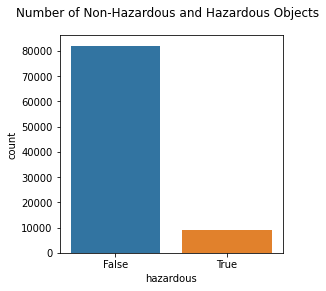

In [12]:
print(df["hazardous"].value_counts() / len(df))

sns.countplot(x='hazardous',data=df)
plt.suptitle('Number of Non-Hazardous and Hazardous Objects')
plt.rcParams['figure.figsize']=[4,4]
plt.show()

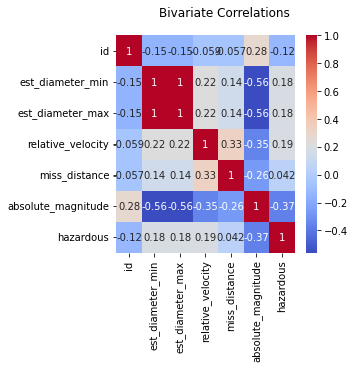

In [13]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.suptitle('Bivariate Correlations')
plt.show()

In [14]:
df.drop(["est_diameter_min"], axis = 1, inplace = True)

In [15]:
df[['drop','temp']]=df.name.str.split('(',expand=True)

df.drop(columns='drop',inplace=True)

def get_year(x):
    return x.strip()[0:x.strip().index(' ')]
df['year']=df['temp'].apply(get_year)
df.drop(columns='temp', inplace=True)

In [16]:
df['year'].unique()

array(['2000', '2005', '2015', '2012', '2014', '2021', '2001', '2016',
       '2020', '2022', '2017', '2018', '2019', '2003', '2006', '2013',
       '1994', '1998', '1978', '1984', '1980', '2007', '2009', '2011',
       '1991', '2004', '2002', '2010', '1990', '2008', '1999', '1993',
       '1997', '1995', '1951', '1950', '1996', '1986', '1992', '1987',
       '1971', '1989', '1960', '1982', '1953', 'A911', '1976', '1973',
       '1936', '1988', '1977', '1937', '1985', '1948', '6743', '1983',
       'A898', '1949', '1974', '1932', '1972', '4788', '6344', '1968',
       '1981', '1979', 'A924', '1947', '1959', '1975', '1929', 'A/2019',
       '1963'], dtype=object)

In [18]:
df.loc[df.year=='A911','year']='1911' 
df.loc[df.year=='6743','year']='1960'
df.loc[df.year=='A898','year']='1898'
df.loc[df.year=='6344','year']='1960'
df.loc[df.year=='A924','year']='1924'
df.loc[df.year=='A/2019','year']='2019'
df.loc[df.year=='4788','year']='1960'

df.year.unique()

array(['2000', '2005', '2015', '2012', '2014', '2021', '2001', '2016',
       '2020', '2022', '2017', '2018', '2019', '2003', '2006', '2013',
       '1994', '1998', '1978', '1984', '1980', '2007', '2009', '2011',
       '1991', '2004', '2002', '2010', '1990', '2008', '1999', '1993',
       '1997', '1995', '1951', '1950', '1996', '1986', '1992', '1987',
       '1971', '1989', '1960', '1982', '1953', '1911', '1976', '1973',
       '1936', '1988', '1977', '1937', '1985', '1948', '1983', '1898',
       '1949', '1974', '1932', '1972', '1968', '1981', '1979', '1924',
       '1947', '1959', '1975', '1929', '1963'], dtype=object)

In [19]:
df.year=df.year.astype(int)

# Univariate and Bivariate Analysis

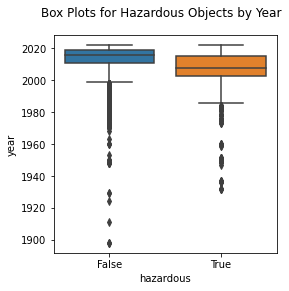

In [20]:
sns.boxplot(x='hazardous',y='year',data=df)
plt.suptitle('Box Plots for Hazardous Objects by Year')
plt.show()

In [21]:
num_cols = ["est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude","year"]

C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\

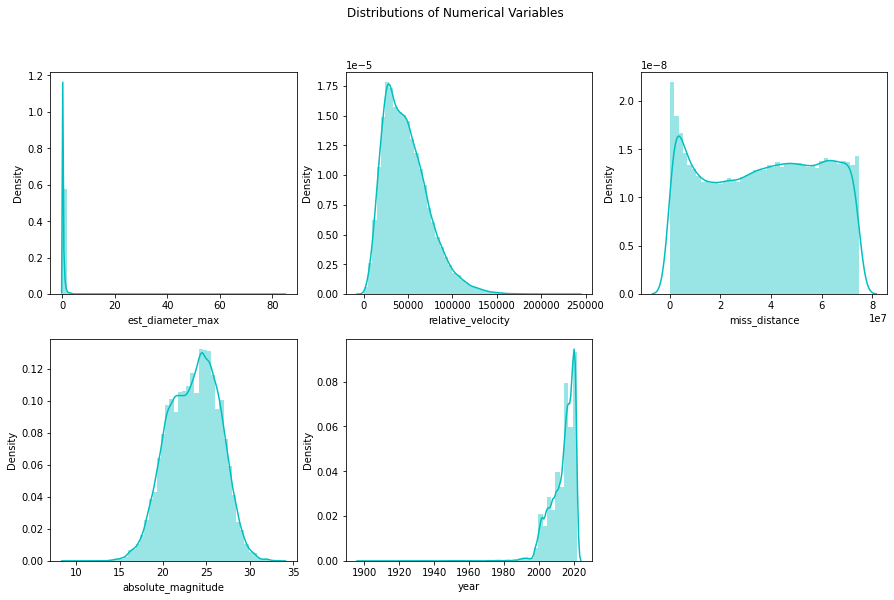

In [22]:
rows=2
cols=3
count=1
plt.rcParams['figure.figsize']=[15,9]
for i in num_cols:
    plt.subplot(rows,cols,count)
    sns.distplot(df[i], color='c')
    count+=1
plt.suptitle('Distributions of Numerical Variables')
plt.show()

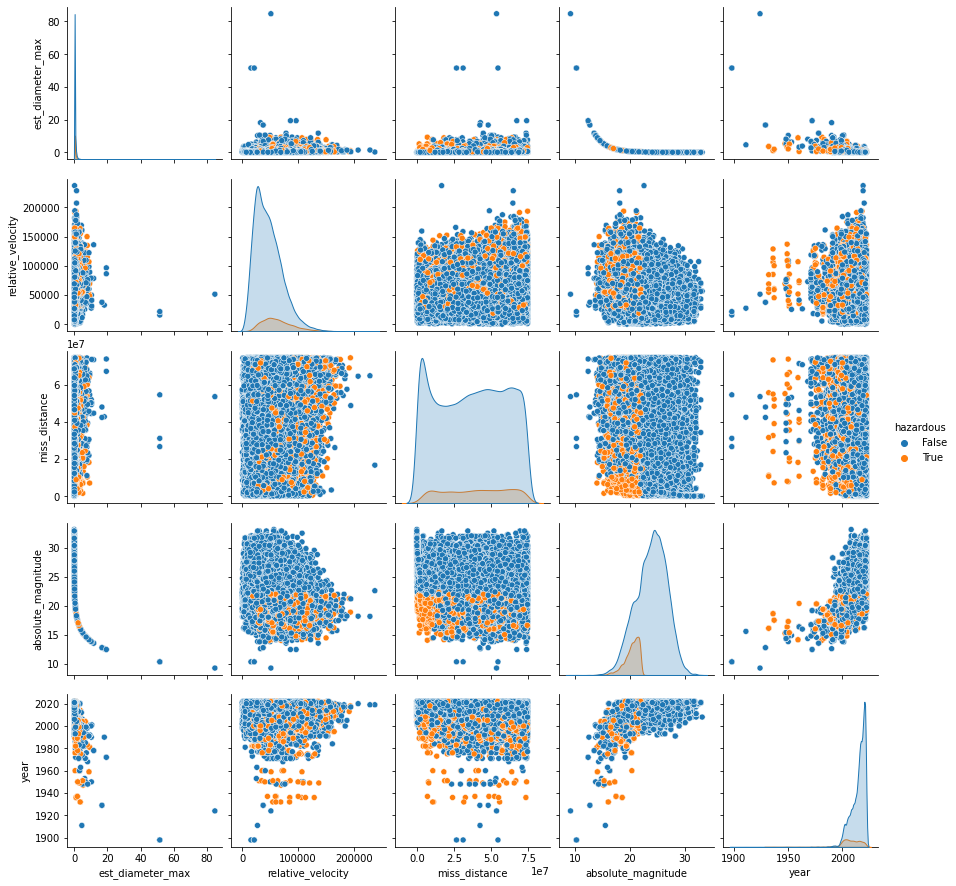

In [23]:
sns.pairplot(df[num_cols+['hazardous']],hue = 'hazardous')

# Model Creation
- Decision Tree Classification Algorithm
- K Nearest Neighbors Classification Algorithm
- Random Forest Classification Algorithm
- Gradient Boosted Decision Tree Classification Algorithm

In [24]:
X = df.drop(["id","name","hazardous"], axis=1)
y = df.hazardous.astype(int)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0, stratify=y)

In [28]:
sc=StandardScaler()
X_train_scaled=pd.DataFrame(sc.fit_transform(X_train))
X_test_scaled=pd.DataFrame(sc.transform(X_test))

In [29]:
def roc_curve_plot(y_test, y_scores, method):
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend()
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of ' + method)
    plt.rcParams['figure.figsize']=[6,5]
    plt.show()
    return roc_auc

In [30]:
DT = DecisionTreeClassifier()
tree = DT.fit(X_train_scaled, y_train)
DT_pred = DT.predict(X_test_scaled)

In [31]:
Acc_DT = round(accuracy_score(DT_pred, y_test), 4)
xgprec_DT, xgrec_DT, xgf_DT, support_DT = score(y_test, DT_pred)
precision_DT, recall_DT, f1_DT = round(xgprec_DT[0], 4), round(xgrec_DT[0],4), round(xgf_DT[0],4)
scores_DT = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [Acc_DT, precision_DT, recall_DT, f1_DT]})
print(scores_DT)

      Metric   Score
0   Accuracy  0.9102
1  Precision  0.9514
2     Recall  0.9490
3         F1  0.9502


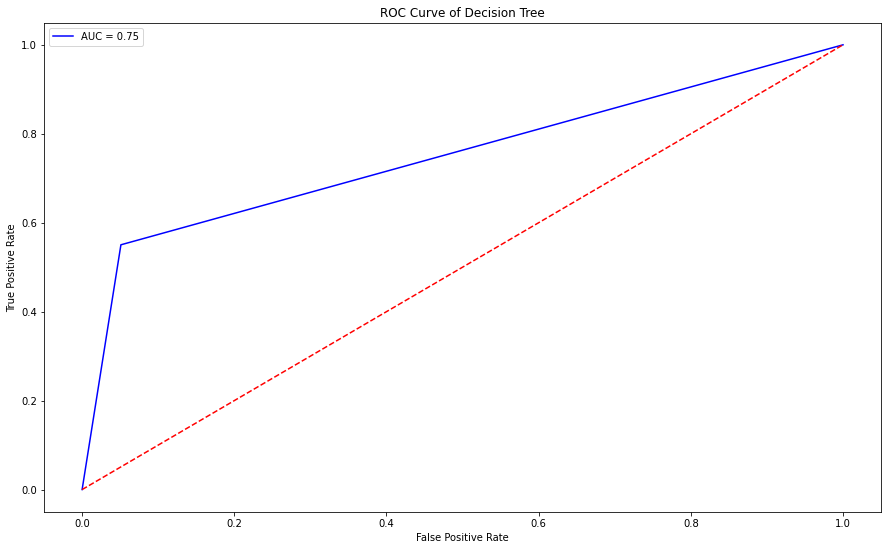

In [32]:
y_scores_DT = DT.predict_proba(X_test_scaled)
auc_DT = roc_curve_plot(y_test, y_scores_DT, 'Decision Tree')

<AxesSubplot:title={'center':'Variable Importance for Decision Tree'}>

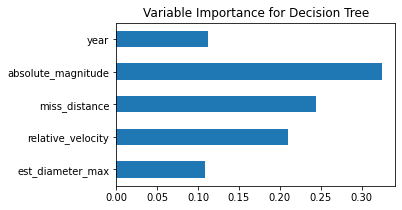

In [33]:
feat_importances = pd.Series(DT.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh', title='Variable Importance for Decision Tree',figsize=[5,3])

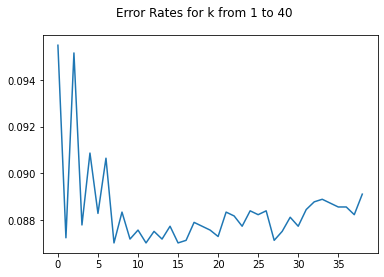

In [34]:
error_rates = []
for i in np.arange(1, 40):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    error_rates.append(np.mean(predictions != y_test))

plt.rcParams['figure.figsize']=[6,4]
plt.suptitle('Error Rates for k from 1 to 40')
plt.plot(error_rates)

In [35]:
KNN = KNeighborsClassifier(n_neighbors = 15)
KNN.fit(X_train_scaled, y_train)
KNN_pred = KNN.predict(X_test_scaled)

In [36]:
Acc_KNN = round(accuracy_score(KNN_pred, y_test), 4)
xgprec_KNN, xgrec_KNN, xgf_KNN, support_KNN = score(y_test, KNN_pred)
precision_KNN, recall_KNN, f1_KNN = round(xgprec_KNN[0], 4), round(xgrec_KNN[0],4), round(xgf_KNN[0],4)
scores_KNN = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [Acc_KNN, precision_KNN, recall_KNN, f1_KNN]})
print(scores_KNN)

      Metric   Score
0   Accuracy  0.9123
1  Precision  0.9250
2     Recall  0.9825
3         F1  0.9529


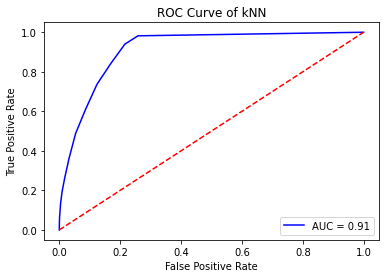

In [37]:
y_scores_KNN = KNN.predict_proba(X_test_scaled)
auc_KNN = roc_curve_plot(y_test, y_scores_KNN, 'kNN')

In [38]:
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_train_scaled, y_train)

print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

Best: [0.90268069 0.90268069 0.90268069 0.91619422 0.91613918 0.91608413
 0.92813894 0.92794628 0.9276573 ], using {'max_depth': 16, 'n_estimators': 64}


In [39]:
RF = RandomForestClassifier()
RF.fit(X_train_scaled, y_train)
RF_pred = RF.predict(X_test_scaled)

In [40]:
Acc_RF = round(accuracy_score(RF_pred, y_test), 4)
xgprec_RF, xgrec_RF, xgf_RF, support_RF = score(y_test, RF_pred)
precision_RF, recall_RF, f1_RF = round(xgprec_RF[0], 4), round(xgrec_RF[0],4), round(xgf_RF[0],4)
scores_RF = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [Acc_RF, precision_RF, recall_RF, f1_RF]})
print(scores_RF)

      Metric   Score
0   Accuracy  0.9393
1  Precision  0.9505
2     Recall  0.9840
3         F1  0.9670


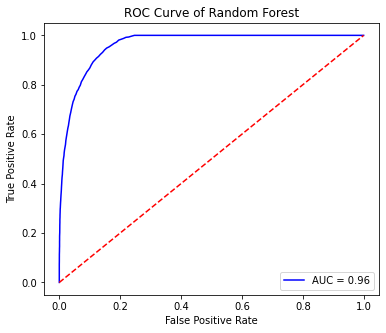

In [41]:
y_scores_RF = RF.predict_proba(X_test_scaled)
auc_RF = roc_curve_plot(y_test, y_scores_RF, 'Random Forest')

<AxesSubplot:title={'center':'Variable Importance for Random Forest'}>

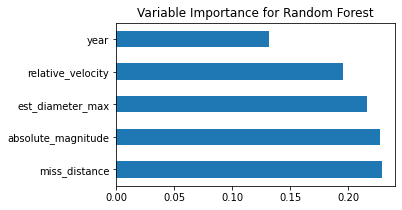

In [42]:
feat_importances_RF = pd.Series(RF.feature_importances_, index=X.columns)
feat_importances_RF.nlargest(8).plot(kind='barh', title = 'Variable Importance for Random Forest', figsize=[5,3])

In [43]:
XGB = XGBClassifier()
XGB.fit(X_train_scaled, y_train)
XGB_pred = XGB.predict(X_test_scaled)

In [44]:
Acc_XGB = round(accuracy_score(XGB_pred, y_test),4)
xgprec_XGB, xgrec_XGB, xgf_XGB, support_XGB = score(y_test, XGB_pred)
precision_XGB, recall_XGB, f1_XGB = round(xgprec_XGB[0], 4), round(xgrec_XGB[0],4), round(xgf_XGB[0],4)
scores_XGB = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [Acc_XGB, precision_XGB, recall_XGB, f1_XGB]})
print(scores_XGB)

      Metric   Score
0   Accuracy  0.9273
1  Precision  0.9343
2     Recall  0.9891
3         F1  0.9609


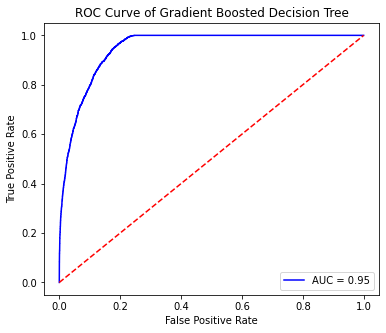

In [45]:
y_scores_XGB = XGB.predict_proba(X_test_scaled)
auc_XGB = roc_curve_plot(y_test, y_scores_XGB, 'Gradient Boosted Decision Tree')

<AxesSubplot:title={'center':'Variable Importance for Gradient Boosted Tree'}>

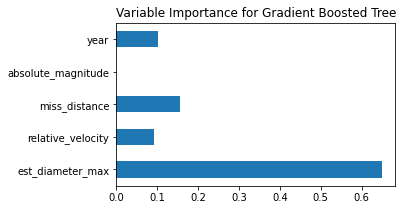

In [46]:
feat_importances_XGB = pd.Series(XGB.feature_importances_, index=X.columns)
feat_importances_XGB.plot(kind='barh', title = 'Variable Importance for Gradient Boosted Tree', figsize=[5,3])

# Comparison Among Models

In [47]:
total_table = pd.DataFrame({
    'Model': ['Random Forest', 'XG Boost','K Nearest Neighbors', 'Decision tree'],
    'AUC': [auc_RF, auc_XGB, auc_KNN, auc_DT],
    'Accuracy': [Acc_RF, Acc_XGB, Acc_KNN, Acc_DT],
    'Precision': [precision_RF, precision_XGB, precision_KNN, precision_DT],
    'Recall': [recall_RF, recall_XGB, recall_KNN, recall_DT],
    'F1': [f1_RF, f1_XGB, f1_KNN, f1_DT]})
total_table.sort_values(by='AUC', ascending=False)

,Model,AUC,Accuracy,Precision,Recall,F1
0,Random Forest,0.962188,0.9393,0.9505,0.9840,0.9670
1,XG Boost,0.948520,0.9273,0.9343,0.9891,0.9609
2,K Nearest Neighbors,0.913124,0.9123,0.9250,0.9825,0.9529
3,Decision tree,0.749682,0.9102,0.9514,0.9490,0.9502


# Conclusion
- Non-hazardousobjects are more than hazardous objects.
- Heatmap on Bivariate Correlation is shown.
- Univariate and Bivariate Analysis is done.
- For bivariate analysis,it seems that hazardous asteroids move slightly faster than non-hazardous ones and we also see that hazardous asteroids actually tend to be further away from earth, which is counter-intuitive.
- Four different types of Models are created.
- Overall, it is clear that both Random Forest classification and Gradient Boosted classification outperformed the Decision Tree and K Nearest Neighbors. They both had very high AUC, accuracy, and recall scores.
- The variable importance plots revealed that the diameter of an asteroid is the main predictor of its danger.
-  We also see from the variable importance plots that the year the asteroid was discovered does impact its hazard classification, possibly due to changing technology at NASA.